# Week 08 — Training Pathologies

This notebook explores common failure modes and their fixes. You'll:
- Diagnose vanishing/exploding gradients
- Compare activation functions and their effects
- Apply fixes: initialization, normalization, gradient clipping
- Track and visualize gradient flow

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

np.random.seed(42)
torch.manual_seed(42)
print("Libraries imported!")

Libraries imported!


In [3]:

import os, pickle

CACHE_DIR = "cache_week08"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week08


## 1. Track Gradient Norms Across Layers

Build a deep network and monitor gradient magnitudes to detect vanishing/exploding gradients.

[cache] computing 'gradient_norm_analysis_10layers'...
sigmoid : [7.133194923625297e-09, 3.749717336631875e-08, 2.048619194283674e-07, 1.4638883385487134e-06, 1.0355174708820414e-05] ...
tanh    : [0.002355444710701704, 0.005402362439781427, 0.006261559668928385, 0.008474514819681644, 0.013164717704057693] ...
relu    : [0.000171330088051036, 0.00043123122304677963, 0.00037125012022443116, 0.0005355750909075141, 0.0009506660862825811] ...


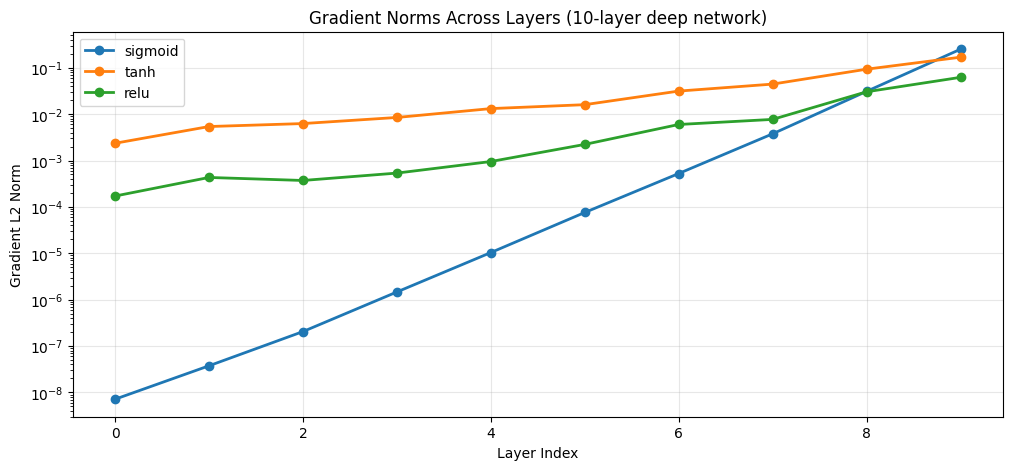


→ Sigmoid/Tanh show vanishing gradients in early layers!
→ ReLU maintains better gradient flow.


In [4]:

import torch
import torch.nn as nn
import torch.optim as optim

class DeepNet(nn.Module):
    def __init__(self, input_size=10, hidden_size=50, n_layers=10, activation='sigmoid'):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(n_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, 1))
        if activation == 'sigmoid':   self.activation = nn.Sigmoid()
        elif activation == 'tanh':    self.activation = nn.Tanh()
        elif activation == 'relu':    self.activation = nn.ReLU()
        else: raise ValueError(f"Unknown activation: {activation}")

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

def compute_gradient_norms(model):
    return [layer.weight.grad.norm().item()
            if hasattr(layer, 'weight') and layer.weight.grad is not None else 0.0
            for layer in model.layers]

X = torch.randn(100, 10)
y = torch.randn(100, 1)

def _gradient_norm_analysis():
    norms_dict = {}
    for act in ['sigmoid', 'tanh', 'relu']:
        model = DeepNet(input_size=10, hidden_size=50, n_layers=10, activation=act)
        outputs = model(X)
        loss = nn.MSELoss()(outputs, y)
        loss.backward()
        norms_dict[act] = compute_gradient_norms(model)
        print(f"{act:8s}: {norms_dict[act][:5]} ...")
    return norms_dict

gradient_norms = cached("gradient_norm_analysis_10layers", _gradient_norm_analysis)

plt.figure(figsize=(12, 5))
for act, norms in gradient_norms.items():
    plt.plot(range(len(norms)), norms, 'o-', label=act, linewidth=2, markersize=6)
plt.xlabel('Layer Index'); plt.ylabel('Gradient L2 Norm')
plt.title('Gradient Norms Across Layers (10-layer deep network)')
plt.legend(); plt.grid(alpha=0.3); plt.yscale('log'); plt.show()
print("\n→ Sigmoid/Tanh show vanishing gradients in early layers!")
print("→ ReLU maintains better gradient flow.")


## 2. Activation Function Comparison

Train networks with different activations and compare learning dynamics.

[cache] computing 'activation_comparison_200epochs'...
  Training sigmoid...
    Final loss: 0.986525
  Training tanh...
    Final loss: 0.981035
  Training relu...
    Final loss: 0.985931


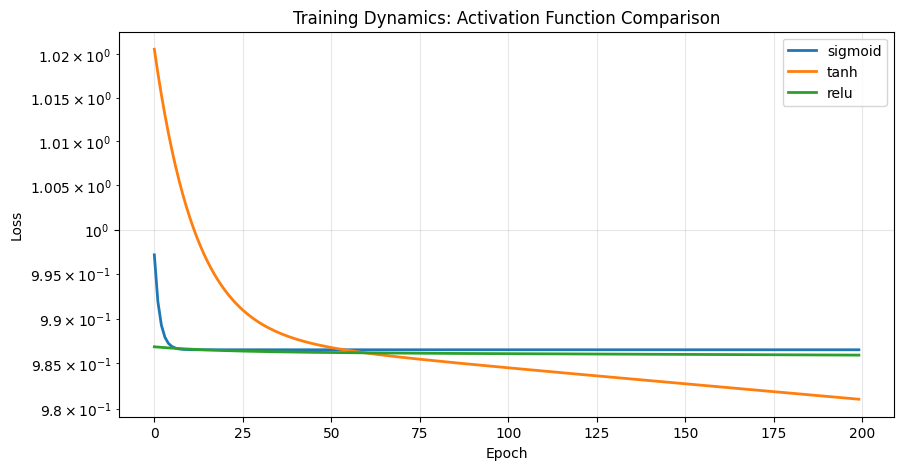

In [5]:

def train_model(model, X, y, n_epochs=200, lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    for _ in range(n_epochs):
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

torch.manual_seed(42)
X_train = torch.randn(500, 10)
y_train = torch.randn(500, 1)

def _activation_comparison():
    results = {}
    for act in ['sigmoid', 'tanh', 'relu']:
        print(f"  Training {act}...")
        model = DeepNet(input_size=10, hidden_size=50, n_layers=6, activation=act)
        losses = train_model(model, X_train, y_train, n_epochs=200, lr=0.01)
        results[act] = losses
        print(f"    Final loss: {losses[-1]:.6f}")
    return results

activation_results = cached("activation_comparison_200epochs", _activation_comparison)

plt.figure(figsize=(10, 5))
for act, losses in activation_results.items():
    plt.plot(losses, label=act, linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Dynamics: Activation Function Comparison')
plt.legend(); plt.grid(alpha=0.3); plt.yscale('log'); plt.show()


## 3. Initialization Strategies

Compare Xavier/Glorot and He initialization to solve gradient problems.

[cache] computing 'init_comparison_relu_200epochs'...
  Training with small init...
    Final loss: 0.986525
  Training with xavier init...
    Final loss: 0.969864
  Training with he init...
    Final loss: 0.562596


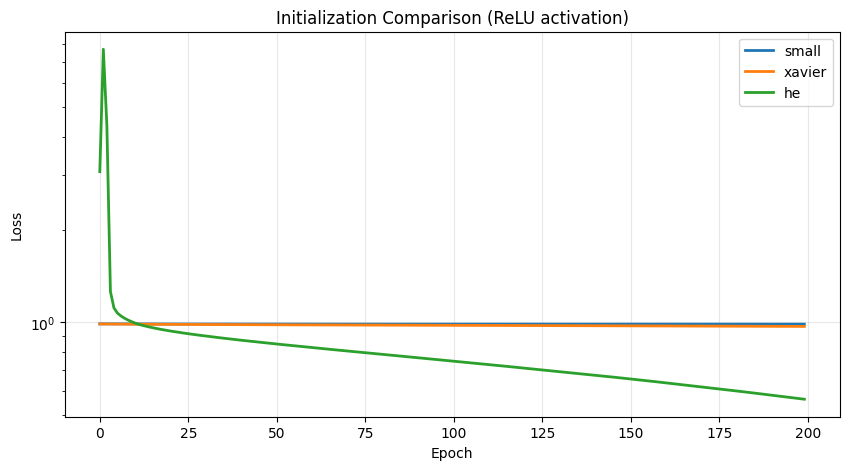


→ He initialization works best with ReLU!


In [6]:

def initialize_model(model, init_type='xavier'):
    for layer in model.layers:
        if hasattr(layer, 'weight'):
            if init_type == 'xavier': nn.init.xavier_uniform_(layer.weight)
            elif init_type == 'he':   nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            elif init_type == 'small': nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias)

def _init_comparison():
    results = {}
    for init_type in ['small', 'xavier', 'he']:
        print(f"  Training with {init_type} init...")
        model = DeepNet(input_size=10, hidden_size=50, n_layers=8, activation='relu')
        initialize_model(model, init_type)
        losses = train_model(model, X_train, y_train, n_epochs=200, lr=0.01)
        results[init_type] = losses
        print(f"    Final loss: {losses[-1]:.6f}")
    return results

init_results = cached("init_comparison_relu_200epochs", _init_comparison)

plt.figure(figsize=(10, 5))
for init_type, losses in init_results.items():
    plt.plot(losses, label=init_type, linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Initialization Comparison (ReLU activation)')
plt.legend(); plt.grid(alpha=0.3); plt.yscale('log'); plt.show()
print("\n→ He initialization works best with ReLU!")


## 4. Batch Normalization

Add BatchNorm to stabilize training and improve gradient flow.

[cache] computing 'batchnorm_comparison_200epochs'...
  Training WITHOUT BatchNorm...
    Final loss: 0.986522
  Training WITH BatchNorm...
    Final loss: 0.000775


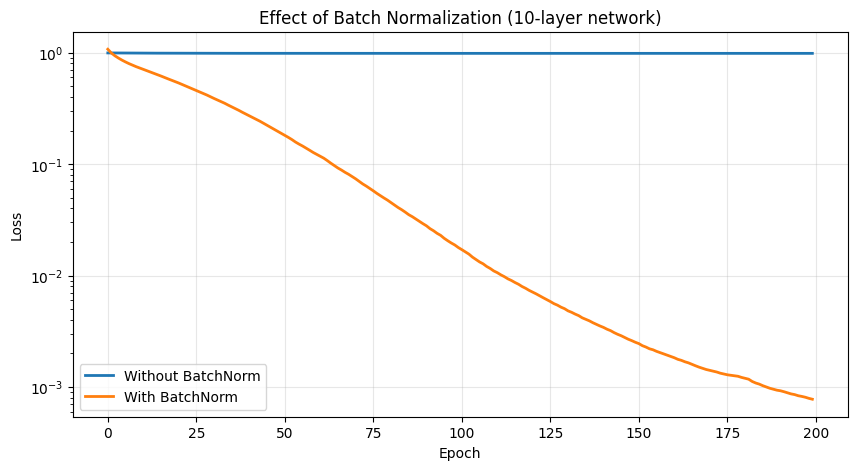

Final loss WITHOUT BatchNorm: 0.986522
Final loss WITH BatchNorm:    0.000775


In [7]:

class DeepNetWithBatchNorm(nn.Module):
    def __init__(self, input_size=10, hidden_size=50, n_layers=10):
        super().__init__()
        self.layers     = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norms.append(nn.BatchNorm1d(hidden_size))
        for _ in range(n_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.batch_norms.append(nn.BatchNorm1d(hidden_size))
        self.layers.append(nn.Linear(hidden_size, 1))
        self.activation = nn.ReLU()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.batch_norms[i](self.layers[i](x)))
        return self.layers[-1](x)

def _batchnorm_comparison():
    print("  Training WITHOUT BatchNorm...")
    losses_no_bn = train_model(DeepNet(10, 50, 10, 'relu'), X_train, y_train, 200, 0.01)
    print(f"    Final loss: {losses_no_bn[-1]:.6f}")
    print("  Training WITH BatchNorm...")
    losses_bn = train_model(DeepNetWithBatchNorm(10, 50, 10), X_train, y_train, 200, 0.01)
    print(f"    Final loss: {losses_bn[-1]:.6f}")
    return losses_no_bn, losses_bn

losses_no_bn, losses_bn = cached("batchnorm_comparison_200epochs", _batchnorm_comparison)

plt.figure(figsize=(10, 5))
plt.plot(losses_no_bn, label='Without BatchNorm', linewidth=2)
plt.plot(losses_bn,    label='With BatchNorm',    linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Effect of Batch Normalization (10-layer network)')
plt.legend(); plt.grid(alpha=0.3); plt.yscale('log'); plt.show()
print(f"Final loss WITHOUT BatchNorm: {losses_no_bn[-1]:.6f}")
print(f"Final loss WITH BatchNorm:    {losses_bn[-1]:.6f}")


## 5. Gradient Clipping

Use gradient clipping to prevent exploding gradients.

[cache] computing 'gradclip_comparison_100epochs'...
  Training WITHOUT gradient clipping...
  Training WITH gradient clipping...


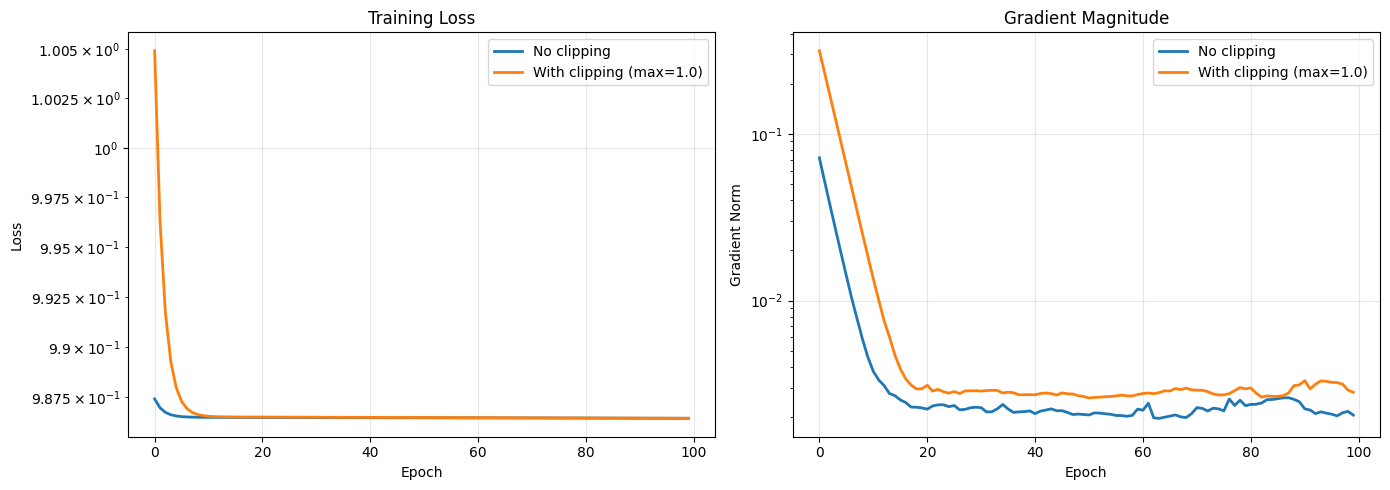


→ Gradient clipping prevents explosions and stabilizes training!


In [8]:

def train_with_clipping(model, X, y, n_epochs=100, lr=0.01, clip_value=None):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses, grad_norms = [], []
    for _ in range(n_epochs):
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        total_norm = sum(p.grad.data.norm(2).item() ** 2 for p in model.parameters() if p.grad is not None) ** 0.5
        grad_norms.append(total_norm)
        if clip_value is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        losses.append(loss.item())
    return losses, grad_norms

def _gradclip_comparison():
    print("  Training WITHOUT gradient clipping...")
    l_nc, g_nc = train_with_clipping(DeepNet(10, 50, 8, 'relu'), X_train, y_train, 100, 0.1, None)
    print("  Training WITH gradient clipping...")
    l_c,  g_c  = train_with_clipping(DeepNet(10, 50, 8, 'relu'), X_train, y_train, 100, 0.1, 1.0)
    return l_nc, g_nc, l_c, g_c

losses_no_clip, grads_no_clip, losses_clip, grads_clip = cached(
    "gradclip_comparison_100epochs", _gradclip_comparison)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(losses_no_clip, label='No clipping',              linewidth=2)
axes[0].plot(losses_clip,    label='With clipping (max=1.0)', linewidth=2)
axes[0].set(xlabel='Epoch', ylabel='Loss', title='Training Loss')
axes[0].legend(); axes[0].grid(alpha=0.3); axes[0].set_yscale('log')
axes[1].plot(grads_no_clip, label='No clipping',              linewidth=2)
axes[1].plot(grads_clip,    label='With clipping (max=1.0)', linewidth=2)
axes[1].set(xlabel='Epoch', ylabel='Gradient Norm', title='Gradient Magnitude')
axes[1].legend(); axes[1].grid(alpha=0.3); axes[1].set_yscale('log')
plt.tight_layout(); plt.show()
print("\n→ Gradient clipping prevents explosions and stabilizes training!")


## Exercises for Further Practice

1. **Layer Normalization**: Implement and compare LayerNorm to BatchNorm
2. **Residual Connections**: Add skip connections to improve gradient flow
3. **Different Depths**: Test very deep networks (20+ layers) with and without fixes
4. **Learning Rate Analysis**: Study how LR interacts with initialization and normalization
5. **Real Data**: Apply these techniques to MNIST or CIFAR-10

## Deliverables Checklist

- [ ] Gradient norm tracking across layers with visualizations
- [ ] Activation function comparison experiments
- [ ] Initialization and BatchNorm experiments
- [ ] Gradient clipping demonstration
- [ ] Short write-up on which fixes work best for which pathologies

## Recommended Resources

- Glorot & Bengio (2010): "Understanding the difficulty of training deep feedforward neural networks"
- Ioffe & Szegedy (2015): "Batch Normalization"
- He et al. (2015): "Delving Deep into Rectifiers" (He initialization)
- PyTorch documentation on initialization and normalization

In [9]:

# EXERCISE 1 — Layer Normalization vs Batch Normalization
# Goal: implement a DeepNetWithLayerNorm class using nn.LayerNorm instead of nn.BatchNorm1d.
# Compare training loss curves: BatchNorm vs LayerNorm vs no normalization.
# Use cached("layernorm_vs_batchnorm_200epochs", ...) for the experiment.
# Expected insight: LayerNorm works on batch size 1, BatchNorm needs a batch of size > 1.


In [10]:

# EXERCISE 2 — Residual Connections
# Goal: implement DeepNetResidual where each hidden layer has a skip connection:
# output = activation(layer(x)) + x (requires equal input/output size).
# Compare gradient norms across layers to the baseline DeepNet.
# Use cached("residual_gradient_norms_10layers", ...) to save the norms.
# Expected insight: skip connections prevent vanishing gradients by providing a
# gradient "highway" directly to early layers.


In [11]:

# EXERCISE 4 — LR × Initialization Interaction
# Goal: create a 3×3 grid: init ∈ {small, xavier, he} × lr ∈ {0.001, 0.01, 0.1}.
# For each combo, train for 200 epochs and record final loss.
# Display final losses as a heatmap using plt.imshow or seaborn.
# Use cached(f"lr_init_grid_{init}_{lr}", ...) per cell.
# Expected insight: some (init, lr) pairs diverge or plateau — the interaction matters.
